## Load data

In [1]:
# Import the dataset loading function from sklearn
from sklearn.datasets import load_digits

# Load the hand-written digits dataset
digits = load_digits()

# Get the images and corresponding labels
images, labels = digits.images, digits.target
images.shape, labels.shape

((1797, 8, 8), (1797,))

In [2]:
import numpy as np
np.max(images), np.max(labels), np.min(images), np.min(labels)

(16.0, 9, 0.0, 0)

## Exploratory data analysis & Data preprocessing &  feature engineering

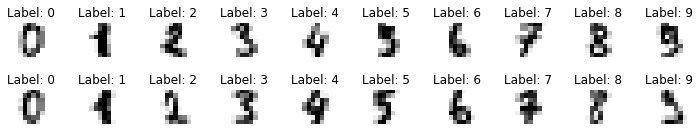

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# plot first 20 images
n = 20
_, axes = plt.subplots(2, 10, figsize=(10, 2))
plt.tight_layout()
for i in range(n):
    row, col = i // 10, i % 10
    axes[row, col].set_axis_off()
    axes[row, col].imshow(images[i,], cmap=plt.cm.gray_r, interpolation='nearest')
    axes[row, col].set_title('Label: %i' % labels[i])

In [4]:
# reshape images to vectors
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
X.shape

(1797, 64)

In [5]:
# Split data into train and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, shuffle=False)

print("Shape of the training data: {}".format(X_train.shape))
print("Shape of the testing data: {}".format(X_test.shape))

Shape of the training data: (1437, 64)
Shape of the testing data: (360, 64)


In [6]:
X_train.shape, X_test.shape

((1437, 64), (360, 64))

### PCA

In [7]:
from sklearn.decomposition import PCA
n_components = 10
pca = PCA(n_components=n_components).fit(X_train) # , svd_solver='randomized',whiten=True
X_train_pca = pca.transform(X_train)

print(X_train.shape)
print(X_train_pca.shape)

(1437, 64)
(1437, 10)


In [8]:
X_train.shape, X_train_pca.shape

((1437, 64), (1437, 10))

0.7388976624885785

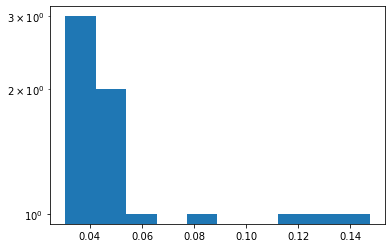

In [9]:
plt.hist(pca.explained_variance_ratio_, bins=10, log=True)
pca.explained_variance_ratio_.sum()

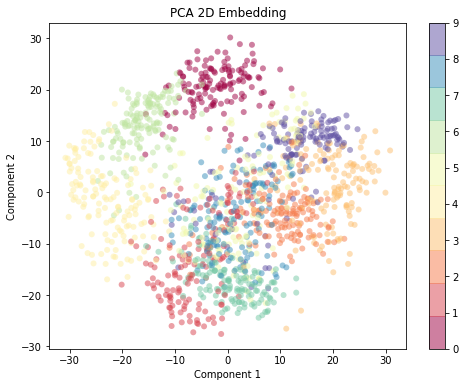

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA 2D Embedding')
plt.colorbar();

### TSNE

In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)

X_train_tsne = tsne.fit_transform(X_train)

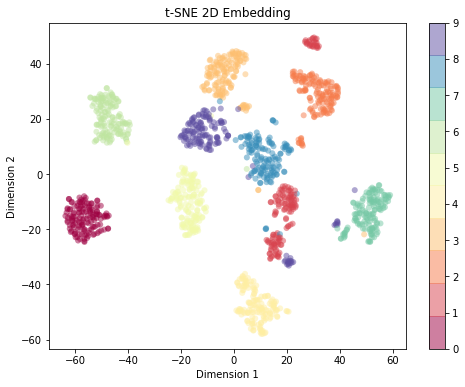

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE 2D Embedding')
plt.colorbar();

## Build up SVM classifier

### Training

In [13]:
# Import library for support vector machine classifier
from sklearn.svm import SVC

# Create a support vector classifier
clf = SVC(C=1, kernel='linear', random_state=42)

# Train the model using the training sets
clf.fit(X_train, y_train)


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

### Testing

The prediction accuracy: 93.06 %


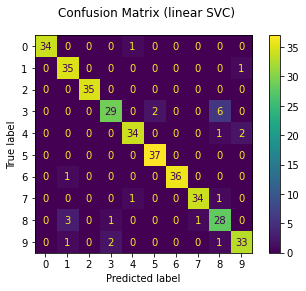

In [14]:
from sklearn.metrics import accuracy_score

# Now predict the value of the digit on the test set:
y_pred_test = clf.predict(X_test)


# Display the testing results
acc = accuracy_score(y_test, y_pred_test)
print("The prediction accuracy: {:.2f} %".format(acc * 100))

from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix (linear SVC)")

plt.show()

### PCA (10 components) + SVC

### Build a pipeline

In [15]:
from sklearn.pipeline import Pipeline
image_clf = Pipeline([
    ('pca', PCA(n_components=10)),
    ('clf', SVC(C=1, kernel='linear', random_state=42)),])

image_clf.fit(X_train, y_train)

# Test
y_pred_test = image_clf.predict(X_test)

# Display the testing results
acc = accuracy_score(y_test, y_pred_test)
print("The prediction accuracy: {:.2f} %".format(acc * 100))

The prediction accuracy: 89.44 %


## Fine-Tuning: jointly tune the PCA components and SVC

In [16]:
# Hp tuning with Sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# Create a dictionary for all the hyperparameters
hps = {
  'pca__n_components': [2, 5, 10, 20],
  'clf__C': [0.05, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15],
  'clf__kernel': ['linear', 'rbf'],  
}

# Construct a scoring function for performance estimation.
scoring_fnc = make_scorer(accuracy_score)

# Create the grid search cv object (5-fold cross-validation)
grid_search = GridSearchCV(estimator=image_clf, 
                           param_grid=hps, 
                           scoring=scoring_fnc, 
                           cv=3,
                           verbose=5,
                           n_jobs=-1) 

# Fit the grid search object to the training data to search the optimal model
grid_search = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.0s finished


In [17]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.5831593597773138 {'clf__C': 0.05, 'clf__kernel': 'linear', 'pca__n_components': 2}
0.8462073764787753 {'clf__C': 0.05, 'clf__kernel': 'linear', 'pca__n_components': 5}
0.9269311064718163 {'clf__C': 0.05, 'clf__kernel': 'linear', 'pca__n_components': 10}
0.9387613082811413 {'clf__C': 0.05, 'clf__kernel': 'linear', 'pca__n_components': 20}
0.5720250521920668 {'clf__C': 0.05, 'clf__kernel': 'rbf', 'pca__n_components': 2}
0.8469032707028532 {'clf__C': 0.05, 'clf__kernel': 'rbf', 'pca__n_components': 5}
0.894224077940153 {'clf__C': 0.05, 'clf__kernel': 'rbf', 'pca__n_components': 10}
0.9018789144050104 {'clf__C': 0.05, 'clf__kernel': 'rbf', 'pca__n_components': 20}
0.5803757828810021 {'clf__C': 0.1, 'clf__kernel': 'linear', 'pca__n_components': 2}
0.8496868475991649 {'clf__C': 0.1, 'clf__kernel': 'linear', 'pca__n_components': 5}
0.9241475295755045 {'clf__C': 0.1, 'clf__kernel': 'linear', 'pca__n_components': 10}
0.9394572025052191 {'clf__C': 0.1, 'clf__kernel': 'linear', 'pca__n_componen

## Retrive the best model

The best combination of hyperparameters are:
clf__C: 3
clf__kernel: 'rbf'
pca__n_components: 20
The prediction accuracy on training set: 99.93 %
The prediction accuracy on test set: 96.67 %


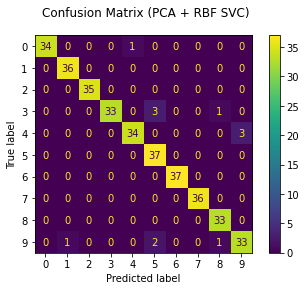

In [18]:
grid_search.best_params_
best_pipeline = grid_search.best_estimator_

# Produce the value for 'max_depth'
print("The best combination of hyperparameters are:")

for hp_name in sorted(hps.keys()):
    print("%s: %r" % (hp_name, grid_search.best_params_[hp_name]))

# Model prediction on training & test data
y_pred_train = best_pipeline.predict(X_train)
y_pred_test = best_pipeline.predict(X_test)

# Display the testing results
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print("The prediction accuracy on training set: {:.2f} %".format(train_acc * 100))
print("The prediction accuracy on test set: {:.2f} %".format(test_acc * 100))

disp = plot_confusion_matrix(best_pipeline, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix (PCA + RBF SVC)")

plt.show()